In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor, XGBRFRegressor
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from datasetRegression import DataSetRegression
from tqdm.auto import tqdm

### I use my class for dataset regression 

In [5]:
class Hdata(DataSetRegression):
    def log_y(self):
        self.y = np.log(self.y)
    
    def unlog_y(self):
        self.y = np.e**self.y
        
    def write_answers(self, out_file, predicted):
        answers = pd.read_csv('HAnswers.csv')
        answers['SalePrice'] = predicted
        answers.to_csv(f'{out_file}.csv', index=False)
    
    def predict(self, Model, params, n_splits=5):
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=40)
        errors = []
        self.models = []
        for train, test in kf.split(self.all_train_data):
            model = Model(**params)
            model.fit(self.all_train_data.iloc[train], self.y.iloc[train])
            self.models.append(model)
            y_pred = model.predict(self.all_train_data.iloc[test])
            error = mean_squared_error(y_pred, self.y.iloc[test], squared=False)
            print('{:5.3f}'.format(error))
            errors.append(error)
        print('total: {:5.3f}'.format(np.mean(errors)))

train_data = pd.read_csv('Htrain.csv')
test_data = pd.read_csv('Htest.csv')
all_data = pd.concat([train_data, test_data])

y = train_data.SalePrice
X = all_data.drop(columns=['Id', 'SalePrice'])
dataset = Hdata(X, y)

# Have a look at data

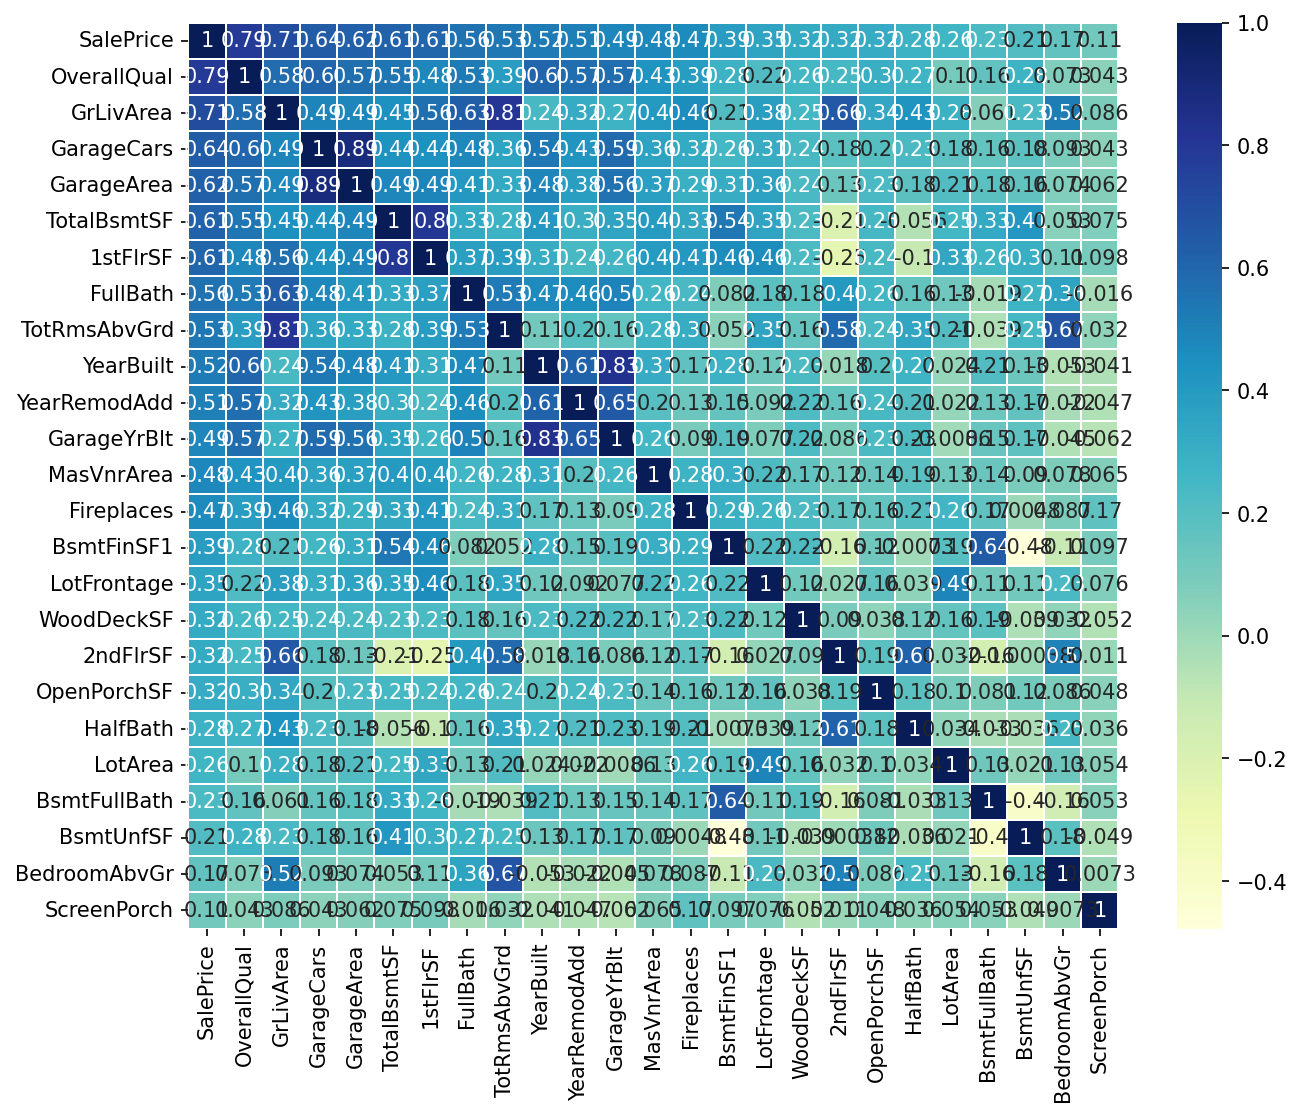

In [6]:
dataset.correlation_matrix();

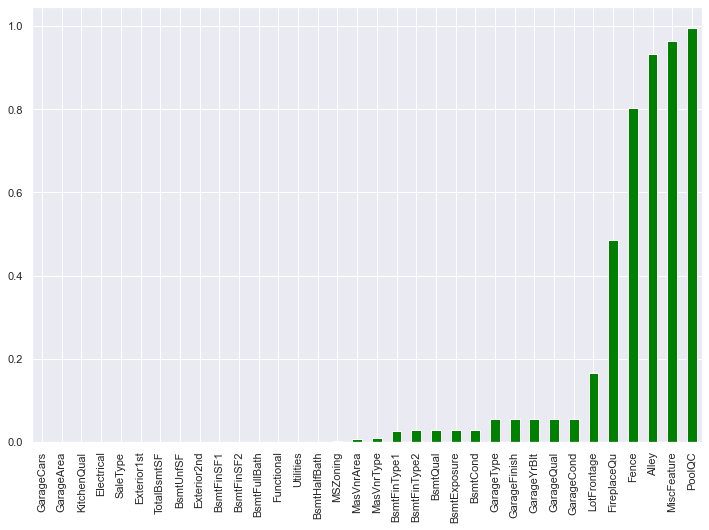

In [7]:
sns.set(rc={'figure.figsize':(12, 8)})
dataset.show_miss_data();

### Fill na
GarageYrBlt fill na to year build </br>
na2no - there is no these objects so I put 'no' </br>
na2zero - there is no this objects (for example Garage) </br>
na2mode - there is no information </br>
some info about garage year build is about feauture (mistakes 2010 - 2100) so i put 2010 as maximum </br>

In [8]:
dataset.X['GarageYrBlt'] = dataset.X['GarageYrBlt'].fillna(dataset.X.loc[dataset.X.GarageYrBlt.isnull()].YearBuilt)
na2no = ['MasVnrType', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtExposure', 'BsmtCond', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
na2mode = ['KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 'Functional', 'Utilities', 'MSZoning']
na2zero = ['BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea', 'LotFrontage']
dataset.X[na2no] = dataset.X[na2no].fillna('No') # Nan = no this feature
dataset.X[na2zero] = dataset.X[na2zero].fillna(0)
dataset.X.loc[dataset.X.GarageYrBlt > 2010, ['GarageYrBlt']] = 2010
dataset.fill_na_mode(na2mode)

In [9]:
dataset.show_miss_data();

There is no missing data


### encoders
Log target because in competition they use "Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price." </br>
ordinal encoder for objects (it is better for xgb then one hot encoder) and standart scale for number </br>

In [10]:
dataset.log_y()
dataset.ordinal_encoder(dataset.X.select_dtypes('object').columns)
dataset.standart_scale(dataset.X.select_dtypes(np.number).columns)

# First attempt

### predict our value

In [11]:
params = {'n_estimators': 2048,
'max_depth': 3,
'eta': 0.05,
'subsample': 0.7,
'colsample_bytree': 0.8,
'lambda': 1,
'alpha': 1,
'tree_method': 'gpu_hist'}

dataset.predict(XGBRegressor, params, 10)

0.096
0.130
0.112
0.108
0.132
0.186
0.119
0.132
0.130
0.119
total: 0.126


### predict our value and use mean predictions

In [12]:
predicted = []
for model in dataset.models:
    predicted.append(model.predict(dataset.submission_data)[:, np.newaxis])
dataset.write_answers('xgb10', np.e**np.mean(predicted, axis=0))

### Results on Kaggle - 0.12235

### If we want to use a few features for faster result we can use these:

<AxesSubplot: xlabel='importance', ylabel='name'>

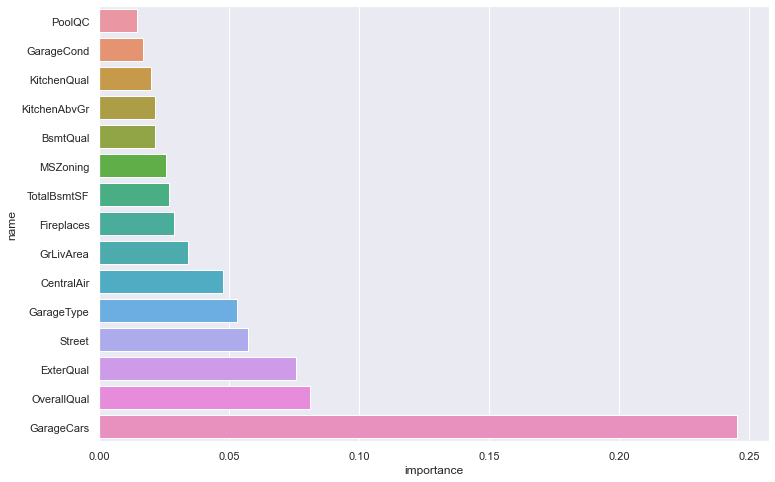

In [13]:
feature_importance = pd.DataFrame({'importance': dataset.models[0].feature_importances_, 'name': dataset.all_train_data.columns})
feature_importance = feature_importance.sort_values('importance')[-15:]
sns.barplot(x=feature_importance['importance'], y=feature_importance['name'])

### Some features have long tails we can log them

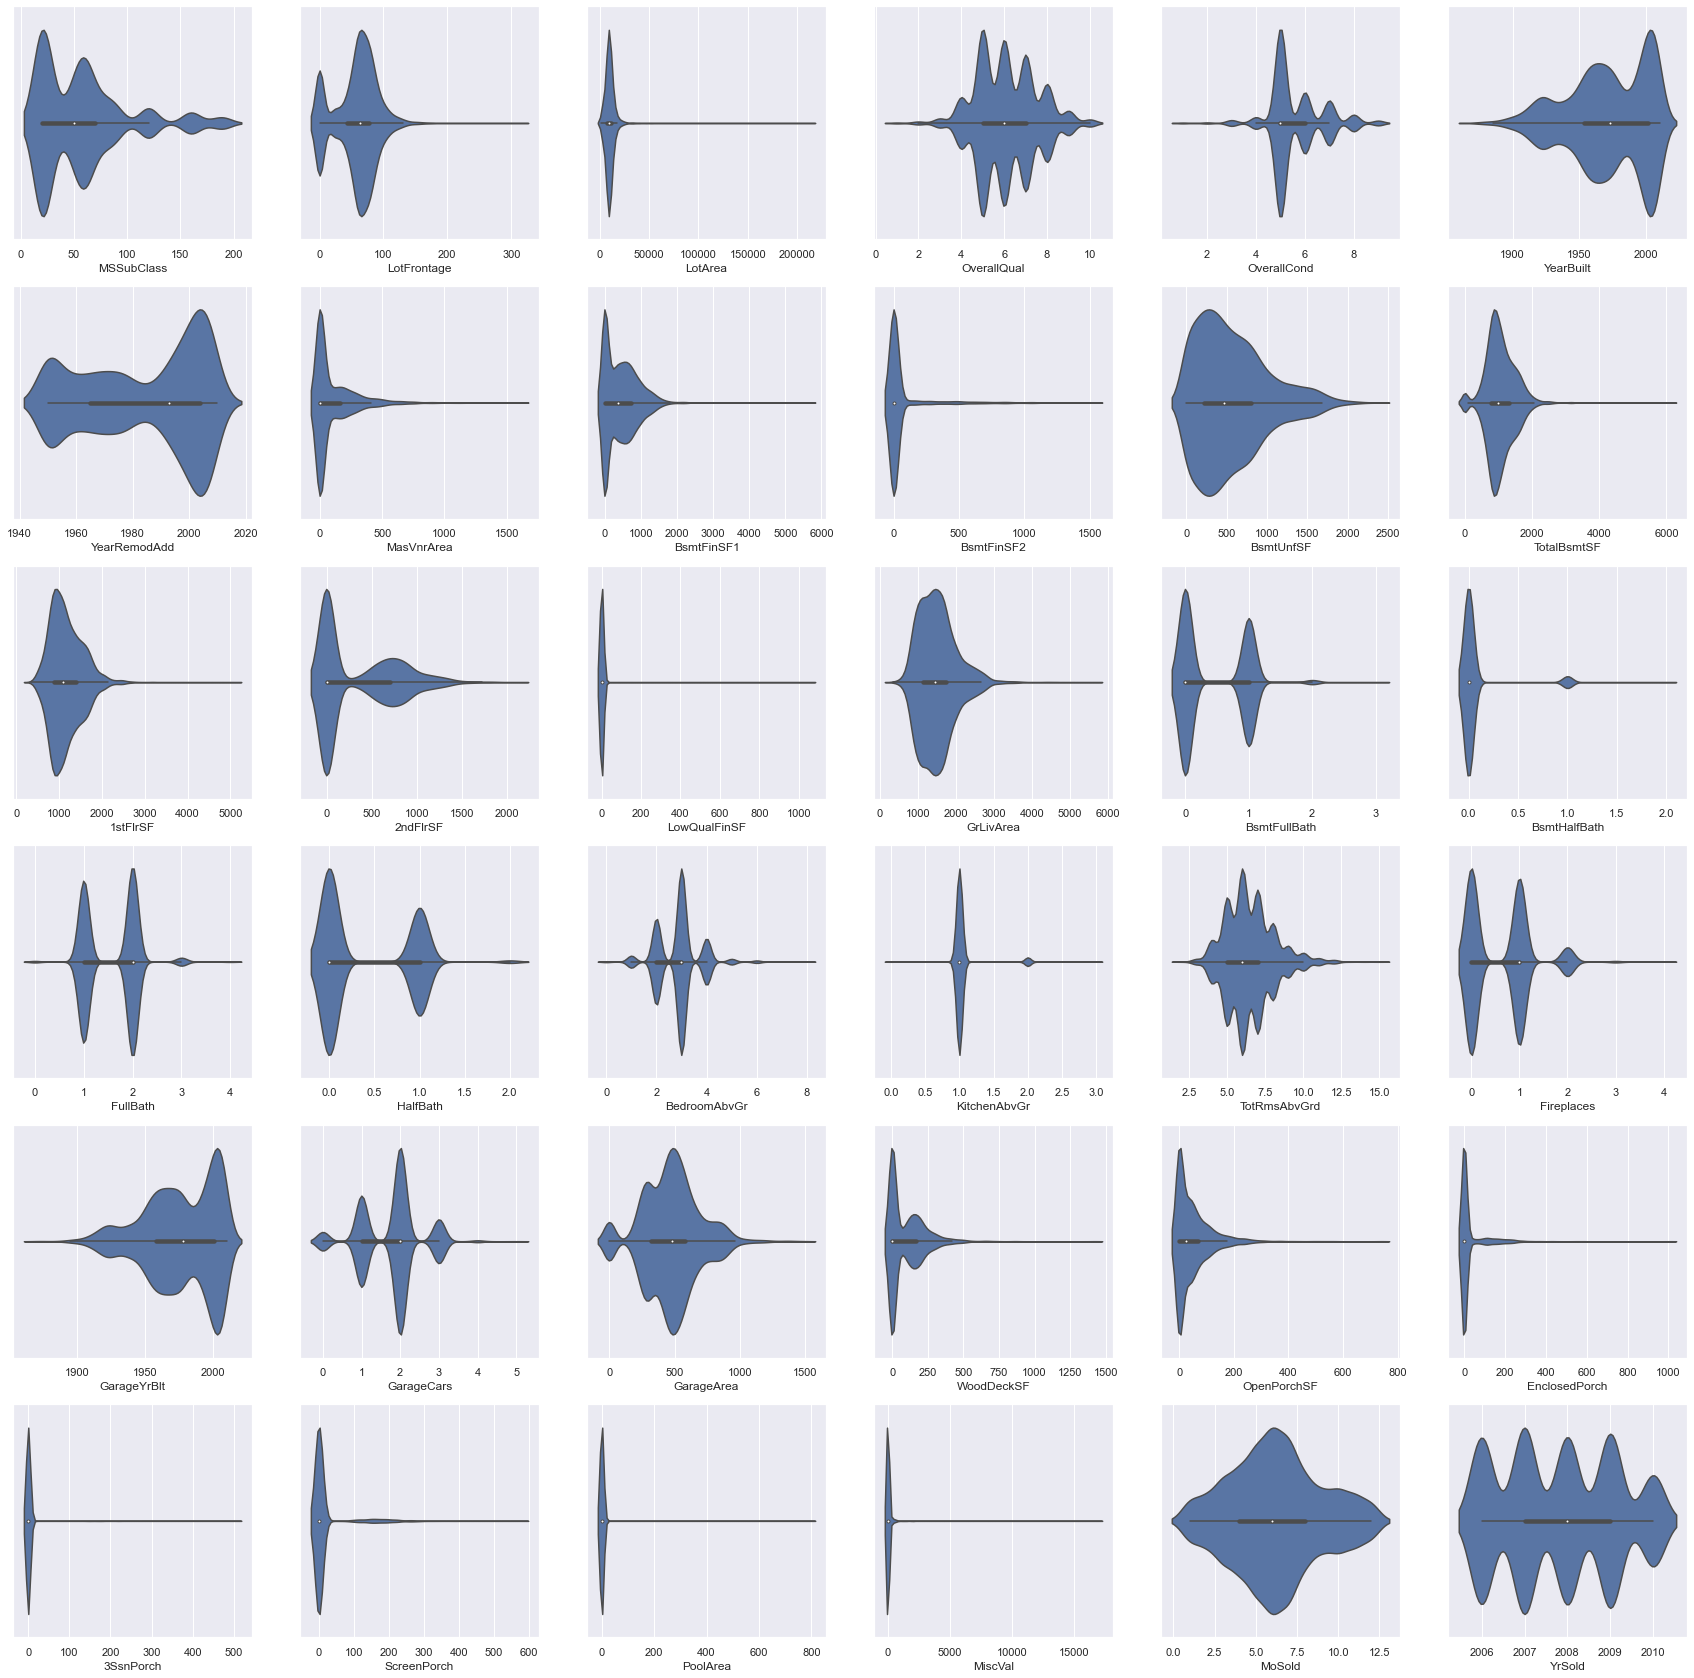

In [14]:
col = dataset.X.select_dtypes(np.number).columns
fig, ax = plt.subplots(6, 6, figsize=(30, 30))
n = 0
for i in range(6):
    for j in range(6):
        sns.violinplot(dataset.X[col[n]], ax=ax[i, j])
        if n < 35:
            n+=1

In [15]:
cols2log = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2','TotalBsmtSF', '1stFlrSF','2ndFlrSF', 'LowQualFinSF','GrLivArea','WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',]
cols2cut = ['OverallQual', 'OverallCond', 'BsmtFullBath', 'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces','GarageCars', 'MoSold']

In [16]:
y = train_data.SalePrice
X = all_data.drop(columns=['Id', 'SalePrice'])
dataset = Hdata(X, y)
dataset.X['GarageYrBlt'] = dataset.X['GarageYrBlt'].fillna(dataset.X.loc[dataset.X.GarageYrBlt.isnull()].YearBuilt)
na2no = ['MasVnrType', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtExposure', 'BsmtCond', 'FireplaceQu', 'Fence', 'Alley', 'MiscFeature', 'PoolQC', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
na2mode = ['KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Electrical', 'Functional', 'Utilities', 'MSZoning']
na2zero = ['BsmtFinSF2', 'BsmtFinSF1', 'TotalBsmtSF', 'GarageArea', 'GarageCars', 'BsmtUnfSF', 'BsmtHalfBath', 'BsmtFullBath', 'MasVnrArea', 'LotFrontage']
dataset.X[na2no] = dataset.X[na2no].fillna('No') # Nan = no this feature
dataset.X[na2zero] = dataset.X[na2zero].fillna(0)
dataset.fill_na_mode(na2mode)
dataset.log_y()
dataset.X[cols2log] = np.log(dataset.X[cols2log]+1)
dataset.ordinal_encoder(dataset.X.select_dtypes('object').columns)
dataset.standart_scale(dataset.X.select_dtypes(np.number).columns)

### Due to the logarithm of house prices, we do not have explicit outliers and this field does not need to be cut by quantiles.

<AxesSubplot: xlabel='SalePrice'>

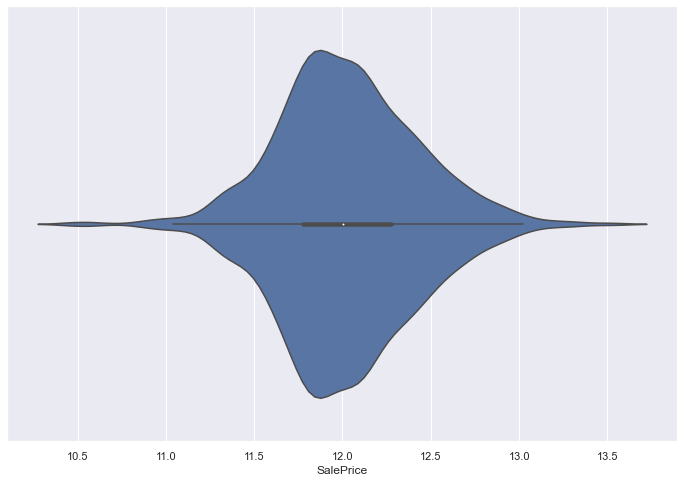

In [17]:
sns.violinplot(dataset.y)

In [20]:
dataset.predict(XGBRegressor, params, 10)

0.096
0.130
0.112
0.108
0.132
0.186
0.119
0.132
0.130
0.119
total: 0.126


In [19]:
predicted = []
for model in dataset.models:
    predicted.append(model.predict(dataset.submission_data)[:, np.newaxis])
dataset.write_answers('xgb10v2', np.e**np.mean(predicted, axis=0))

### The same result on valid data and Kaggle data. It can be usefull for linear regression, but not for xgb regression